In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [ ]:
class CNNEmbedding(nn.Module):
    def __init__(self):
        super(CNNEmbedding, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, (1,3), stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, (1,3), stride=1)
        self.bn2 = nn.BatchNorm2d(128) 
        self.fc1 = nn.Linear(128*1022, 1024)
        self.fc2 = nn.Linear(1024, 512)
        
    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), (1,2)))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), (1,2)))
        return self.fc2(F.relu(self.fc1(torch.flatten(x, 1))))

In [3]:
model = CNNEmbedding()
model.load_state_dict(torch.load('/home/ec2-user/hackathonBio/emily/trained_models/vibrio/sum/model_1.pt'))
model

CNNEmbedding(
  (conv1): Conv2d(1, 64, kernel_size=(1, 3), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(1, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=130816, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
)

In [4]:
embedding_dir = '/mnt/efs/fs1/data/embeddings/vibrio_embeddings/'
metadata_dir = '/mnt/efs/fs1/data/metadata/vibrio/'
test_positive_pairs = pd.read_table(metadata_dir + 'test_positive_pairs.txt')


In [5]:
print(test_positive_pairs['Host_ID'].nunique())
print(test_positive_pairs['Phage_ID'].nunique())


22
23


In [6]:
class TestDataset(Dataset):
    def __init__(self, id_list, method, phage=True):
        self.id_list = id_list
        self.method = method
        self.phage = phage
        
    def normalize_0_1(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())
        
    def __len__(self):
        return len(self.id_list)
    
    def __getitem__(self, idx):
        ID = self.id_list[idx]

        if self.method == 'sum':
            if self.phage:
                try:
                    embed = torch.sum(torch.load(embedding_dir + '/phage_embeddings/' + ID + '.pt'), 0)
                    embed = self.normalize_0_1(embed)
                except:
                    embed = None
            else:
                try:
                    embed = torch.sum(torch.load(embedding_dir + '/host_embeddings/' + ID + '.pt'), 0)
                    embed = self.normalize_0_1(embed)
                except:
                    embed = None
        
        return ID, embed

In [7]:
phage_test_dataset = TestDataset(test_positive_pairs['Phage_ID'].unique(), 'sum')
print(len(phage_test_dataset))
phage_loader = DataLoader(phage_test_dataset, batch_size=len(phage_test_dataset)//2)
bacteria_test_dataset = TestDataset(test_positive_pairs['Host_ID'].unique(), 'sum', phage=False)
print(len(bacteria_test_dataset))
bacteria_loader = DataLoader(bacteria_test_dataset, batch_size=len(bacteria_test_dataset)//2)

23
22


In [8]:
test_positive_pairs_list = [tuple(x) for x in test_positive_pairs[['Phage_ID', 'Host_ID']].values]

In [9]:
def predict(dataset, encoder):
    ids = []
    output_embeddings  = []
    with torch.no_grad():
        for samp in dataset:
            # print(samp[1].size())
            if samp[1] is not None:
                embed = torch.reshape(samp[1], (1, 1, 1, samp[1].size()[0]))
                # print(embed.size())
                ids.append(samp[0])
                output_embeddings.append(encoder(embed))
            else:
                ids.append(samp[0])
                output_embeddings.append(np.nan)

    # ids = np.concatenate(ids)
    # output_embeddings = np.concatenate(output_embeddings)
    
    return ids, output_embeddings

In [10]:
phage_embeddings = predict(phage_test_dataset, model)
bact_embeddings = predict(bacteria_test_dataset, model)

In [11]:
print(len(phage_embeddings))

2


In [12]:
distances = np.zeros((len(phage_test_dataset), len(bacteria_test_dataset)))
print(distances.shape)
match = np.zeros((len(phage_test_dataset), len(bacteria_test_dataset)))
print(match.shape)
phage_labels = []

with tqdm.tqdm(total=len(phage_embeddings[1])) as pbar:
    for i in range(len(phage_embeddings[1])):
        phage = phage_embeddings[1][i]
        phage_labels.append(phage_embeddings[0][i])
        pbar.update(1)
        bacteria_labels = []
        for j in range(len(bact_embeddings[1])):
            bacteria = bact_embeddings[1][j]
            bacteria_labels.append(bact_embeddings[0][j])
            pair_id = (phage_embeddings[0][i], bact_embeddings[0][j])
            if bacteria is not None and phage is not None:
                distances[i][j] = torch.sqrt(torch.sum(torch.pow(phage - bacteria, 2)))
                # print(distances[i][j])
            else:
                distances[i][j] = np.nan
                
            if pair_id in test_positive_pairs_list:
                match[i][j] = 1
            


(23, 22)
(23, 22)


100%|██████████| 23/23 [00:00<00:00, 1576.01it/s]


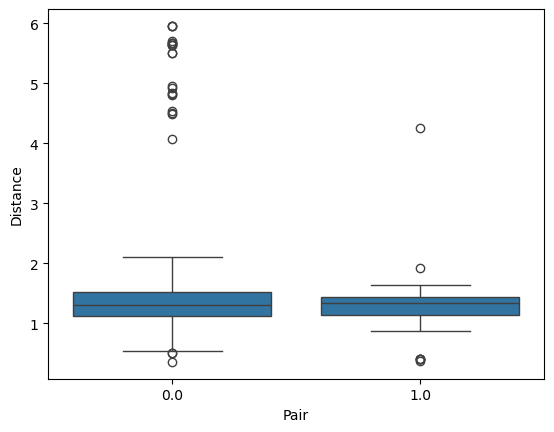

In [13]:
temp = pd.DataFrame([distances.flatten(), match.flatten()], index=['Distance', 'Pair']).transpose()

sns.boxplot(data=temp, x='Pair', y='Distance')
plt.show()

In [14]:
distances_prob = []

for dist in distances:
    distances_prob.append(1 - dist/max(dist))
    
distances_prob = np.vstack(distances_prob)

In [15]:
rows = []

for i in range(distances.shape[0]):
    for j in range(distances.shape[1]):
        rows.append([phage_labels[i], bacteria_labels[j], distances[i][j], distances_prob[i][j]])

# pd.DataFrame(rows, columns=['Phage_ID', 'Host_ID', 'Distance', 'DistanceProb']).to_csv('/home/ec2-user/hackathonBio/emily/trained_models/vibrio/sum/model_1_distances.csv')

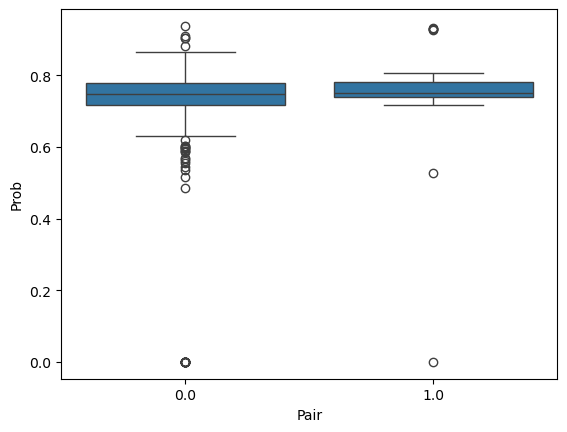

In [16]:
temp = pd.DataFrame([distances_prob.flatten(), match.flatten()], index=['Prob', 'Pair']).transpose()

sns.boxplot(data=temp, x='Pair', y='Prob')
plt.show()

In [17]:
nan_mask = np.where(~np.isnan(distances_prob.flatten()))
roc_auc_score(match.flatten()[nan_mask[0]], distances_prob.flatten()[nan_mask[0]])

0.5789015703415897

In [18]:
for i in range(len(phage_labels)):
    print(phage_labels[i])
    print(distances[i])
    print(distances[i].argsort())
    print(match[i][distances[i].argsort()])

GCA_003931275.1
[1.26259518 0.40020248 1.43435526 1.50527775 1.57729101 1.58867693
 0.91913635 1.03108048 1.34124506 1.52732468 1.5553292  1.25177491
 1.51691616 1.49957573 1.43806028 1.52781546 1.69536006 1.67381072
 5.67555761 1.3191433  1.77569854 1.36093175]
[ 1  6  7 11  0 19  8 21  2 14 13  3 12  9 15 10  4  5 17 16 20 18]
[1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
GCA_003927295.1
[1.17094576 0.37753093 1.28824103 1.37672031 1.41338444 1.43733597
 0.8521601  1.00741696 1.19364786 1.48244894 1.42683005 1.13825166
 1.39076996 1.38020337 1.33456445 1.40769565 1.55875587 1.54220033
 5.50363588 1.22351718 1.56582999 1.28923428]
[ 1  6  7 11  0  8 19  2 21 14  3 13 12 15  4 10  5  9 17 16 20 18]
[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
GCA_003928155.1
[1.26197958 0.40297863 1.43467498 1.50520062 1.57789886 1.58908653
 0.91860098 1.02980506 1.341524   1.52594495 1.55527103 1.25151575
 1.51680195 1.49935758 1.43758786 1.52760863 1.69541